<div style=style="font-size: 16px">
   <center><strong>3η ΥΠΟΧΡΕΩΤΙΚΗ ΕΡΓΑΣΙΑ</strong></center>
</div>
<center>Κωνσταντής Αθανάσιος - ΑΕΜ: 10537</center>

Για την 3η υποχρεωτική εργασία θα γράψουμε ένα πρόγραμμα στην PyTorch το οποίο θα υλοποιεί ένα <strong> Radial Basis Function Neural Network (RBF)</strong> το οποίο θα εκπαιδευτεί για να λύνει το πρόβλημα κατηγοριοποίησης της cifar-10.

Αρχικά, θα εισάγουμε τις βιβλιοθήκες που απαιτούνται στον παρακάτω κώδικά μας.

In [1]:
import torch
from skimage.feature import hog
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import pickle
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

Προσπαθόυμε όπως πάντα να γράφουμε device agnostic code. Αν στο σύστημα στο οποίο τρέχει ο κώδικας υποστηρίζεται το CUDA, ο κώδικάς μας θα τρέχει στην GPU και θα είναι πολύ πιο γρήγορος. Αλλιώς, ο κώδικάς μας θα τρέξει στην CPU.

In [2]:
# Set device type
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Οι παρακάτω συναρτήσεις έχουν χρησιμοποιηθεί σε όλες τις προηγούμενες εργασίες και δεν θα αναλυθούν. Διαβάζουμε την cifar και δημιουργούμε συναρτήσεις για το training, testing και visualization του νευρωνικού μας δικτύου. 

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [12]:
BATCH_SIZE = 32
batches = []
for i in range(5):
    #add to the batches list, the arrays of each batch
    batches.append(unpickle(f"cifar-10-batches-py/data_batch_{i+1}"))
#stack the arrays vertically, resulting in a 50000x3072 matrix
train_data = np.vstack((batches[0][b'data'],batches[1][b'data'],batches[2][b'data'],batches[3][b'data'],batches[4][b'data']),dtype=np.uint8)
#stack the labels horizontally, resulting in a 1x50000 matrix
train_labels = np.hstack((batches[0][b'labels'],batches[1][b'labels'],batches[2][b'labels'],batches[3][b'labels'],batches[4][b'labels']),dtype=np.int64)
#prepare the test data in array form
test_batch = unpickle("cifar-10-batches-py/test_batch")
#numpy array of shape 10000x3072
test_data = test_batch[b'data']
#numpy array of shape 1x10000
test_labels = test_batch[b'labels']


sc = StandardScaler()
train_data_scaled = sc.fit_transform(train_data)
test_data_scaled  = sc.transform(test_data)
pca = PCA(n_components=0.9)
train_data_t = pca.fit_transform(train_data_scaled)
test_data_t  = pca.transform(test_data_scaled)
print(f"train data size = {train_data_t.shape}")


#numpy array holding the training data in image shape
images_sep = train_data.reshape(50000,3,1024).reshape(50000,3,32,32)
#numpy array holding the testing data in image shape
images_sep_t = test_data.reshape(10000,3,1024).reshape(10000,3,32,32)


#Combination of all the data in vector form for batch training
tr_data = TensorDataset(torch.from_numpy(train_data).type(torch.float32).to(device),torch.from_numpy(train_labels).to(device))
te_data = TensorDataset(torch.from_numpy(test_data).type(torch.float32).to(device),torch.tensor(test_labels).to(device))
train_dataloader = DataLoader(tr_data, batch_size=BATCH_SIZE,shuffle=False)
test_dataloader = DataLoader(te_data,batch_size = BATCH_SIZE, shuffle=False)

train_data_t = torch.from_numpy(train_data_t).to(device).type(torch.float32)
test_data_t = torch.from_numpy(test_data_t).to(device).type(torch.float32)
train_data = torch.from_numpy(train_data).to(device).type(torch.float32)
test_data = torch.from_numpy(test_data).to(device).type(torch.float32)
test_labels = torch.Tensor(test_labels).to(device).type(torch.long)
train_labels = torch.from_numpy(train_labels).to(device).type(torch.long)

class_names = [1,2,3,4,5,6,7,8,9,10]

train data size = (50000, 103)


In [5]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    if isinstance(true_labels, torch.Tensor):
        true_labels = true_labels.cpu().numpy()
    if isinstance(predicted_labels, torch.Tensor):
        predicted_labels = predicted_labels.cpu().detach().numpy()

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def accuracy_score(y_pred,y_true):
    return (y_pred == y_true).sum().item()/len(y_pred)

def train_step_batch(model:nn.Module,train_dataloader: DataLoader,loss_fun:nn,optim:torch.optim,scheduler:torch.optim.lr_scheduler.ReduceLROnPlateau=None):
    train_loss = 0
    acc = 0
    for batch, (X,y) in enumerate(train_dataloader):
        model.train()
        y_logits = model(X)
        y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)
        y_loss = loss_fun(y_logits,y)
        train_loss+=y_loss.item()
        acc += accuracy_score(y,y_preds)
        optim.zero_grad()
        y_loss.backward()

        optim.step()

    train_loss /= len(train_dataloader)
    acc /= len(train_dataloader)
    if(scheduler!=None):
            scheduler.step(train_loss)
    return train_loss, acc

def test_step_batch(model:nn.Module,test_dataloader: DataLoader, loss_fun: nn,return_preds:bool = False,return_all:bool = False):
    model.eval()
    test_loss = 0
    test_acc = 0
    predictions = []
    with torch.inference_mode():
        for indx,(X,y) in enumerate(test_dataloader):
            test_logits = model(X)
            test_loss += loss_fun(test_logits,y).item()
            pred_labels = torch.softmax(test_logits,dim=1).argmax(dim=1)
            test_acc += accuracy_score(y,pred_labels)
            if(return_preds or return_all):
                predictions.append(pred_labels.cpu().numpy())
        test_loss /= len(test_dataloader)
        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)
        if(return_preds):
             return np.concatenate(predictions).flatten()
        if(return_all): 
             return np.concatenate(predictions).flatten(),test_loss,test_acc
        return test_loss, test_acc

def train_step(model:nn.Module,train_data:torch.Tensor,train_labels:torch.Tensor,loss_fun:nn,optim:torch.optim,scheduler:torch.optim.lr_scheduler.ReduceLROnPlateau=None):
        model.train()
        acc = 0
        y_logits = model(train_data)
        y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)
        train_loss = loss_fun(y_logits,train_labels)
        acc += accuracy_score(train_labels,y_preds)
        optim.zero_grad()
        train_loss.backward()
        optim.step()
        if(scheduler!=None):
            scheduler.step(train_loss)
        return train_loss,acc

def test_step(model:nn.Module,test_data:torch.Tensor,test_labels:torch.Tensor, loss_fun:nn,return_preds:bool = False,return_all:bool = False):
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        test_logits = model(test_data)
        test_loss = loss_fun(test_logits,test_labels).item()
        pred_labels = torch.softmax(test_logits,dim=1).argmax(dim=1)
        test_acc += accuracy_score(test_labels,pred_labels)
    if(return_preds):
        return pred_labels.cpu().numpy()
    if(return_all):
         return pred_labels.cpu().numpy(), test_loss, test_acc
    return test_loss, test_acc

def train_and_test_model(model:nn.Module,train_data:torch.Tensor,train_labels:torch.Tensor,test_data:torch.Tensor,test_labels:torch.Tensor,loss_fun:nn,optimizer:torch.optim,scheduler:torch.optim.lr_scheduler.ReduceLROnPlateau = None,epochs:int = 100):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    test_accuracies = np.zeros(epochs)
    train_accuracies = np.zeros(epochs)
    for epoch in range(epochs):
        train_losses[epoch],train_accuracies[epoch] = train_step(model,train_data,train_labels,loss_fun,optimizer,scheduler)
        test_losses[epoch],test_accuracies[epoch] = test_step(model,test_data,test_labels,loss_fun)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"epoch {epoch} \ttrain loss: {train_losses[epoch]:.5f} \ttest loss: {test_losses[epoch]:.5f} \ttrain_acc = {train_accuracies[epoch]*100:.2f}\ttest_acc = {test_accuracies[epoch]*100:.2f} \tlr={current_lr}")
    return train_losses, test_losses, test_accuracies, train_accuracies

def train_and_test_model_batch(model:nn.Module,train_dataloader:DataLoader,test_dataloader:DataLoader,loss_fun:nn,optimizer:torch.optim,scheduler:torch.optim.lr_scheduler.ReduceLROnPlateau = None,epochs:int = 100):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    test_accuracies = np.zeros(epochs)
    train_accuracies = np.zeros(epochs)
    for epoch in range(epochs):
        train_losses[epoch],train_accuracies[epoch] = train_step_batch(model,train_dataloader,loss_fun,optimizer,scheduler)
        test_losses[epoch],test_accuracies[epoch] = test_step_batch(model,test_dataloader,loss_fun)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"epoch {epoch} \ttrain loss: {train_losses[epoch]:.5f} \ttest loss: {test_losses[epoch]:.5f} \ttrain_acc = {train_accuracies[epoch]*100:.2f}\ttest_acc = {test_accuracies[epoch]*100:.2f} \tlr={current_lr}")
    return train_losses, test_losses, test_accuracies, train_accuracies

def plot_graphs(train_loss:np.array,test_loss:np.array,train_acc:np.array,test_acc:np.array):
    lin = np.linspace(0,1,len(train_acc))

    axis1 = plt.subplot(211)
    axis2 = plt.subplot(212)
    axis1.plot(lin,train_loss,color='red',label = 'Train loss')
    axis1.plot(lin,test_loss,color='blue',label="Test loss")
    axis1.set_xlabel('epochs')
    axis1.set_ylabel('loss')
    axis1.set_title('Train and test loss per epoch')
    axis1.legend()
    axis1.grid(True)
    
    axis2.plot(lin,train_acc,color='red',label = 'Train accuracy')
    axis2.plot(lin,test_acc,color='blue',label="Test accuracy")
    axis2.set_xlabel('epochs')
    axis2.set_ylabel('accuracy')
    axis2.set_title('Train and test accuracy per epoch')
    axis2.legend()
    axis2.grid(True)
    
    plt.tight_layout()
    plt.show()

def gaussian(d):
    return torch.exp(-d.pow(2))

def compute_centroids(data_points,labels):
    centroids = []
    for i in range(10):
        #mask all data that is in the i-th class and store its mean
        centroids.append(data_points[labels == i].mean(axis=0))
    return centroids

Ήρθε η ωρα να φτιάξουμε το μοντέλο μας. Τα RBF νευρωνικά έχουν πολύ συγκεκριμένη μορφή. Η πληροφορία που εισάγεται περνάει από την συνάρτηση kernel, η οποία είναι μια γκαουσιανή, και μετά εισέρχεται σε ένα γραμμικό layer εξόδου. Η συνάρτηση kernel μας είναι η εξής:
$$
g(x) = e^{-\left(\dfrac{||x-c||}{2\sigma}\right)^2}
$$

Παρακάτω δίνεται το μοντέλο αυτό.

In [10]:
class Model0(nn.Module):
    def __init__(self,basis_func,centers,sigma,num_kernels,input_size = 3072):
        super(Model0, self).__init__()
        self.input_size = input_size
        self.num_kernels = num_kernels
        self.centers = nn.Parameter(centers)
        self.sigmas = nn.Parameter(torch.Tensor(num_kernels))
        self.l1 = nn.Linear(num_kernels,10)
        self.w = nn.Parameter(torch.Tensor(10,10))
        self.sigmas.data.fill_(sigma)
        self.basis_func = basis_func

    def forward(self, x):
        size = (x.size(0), self.num_kernels, self.input_size)
        x = x.unsqueeze(1).expand(size)
        c = self.centers.unsqueeze(0).expand(size)
        distances = (x - c).pow(2).sum(-1).pow(0.5)/((self.sigmas.unsqueeze(0)))
        #print(self.basis_func(distances))
        return self.l1(self.basis_func(distances))

Οι παράμετρος c ορίζει το κέντρο της κάθε γκαουσιανής και η παράμετρος σ την τυπική απόκλισή της. Πρέπει κάπως να αρχικοποιήσουμε τις παραμέτρους αυτές ώστε να συγκλίνουμε σε ένα καλό αποτέλεσμα. Στην θεωρία μάθαμε ότι μια καλή αρχικοποίηση για την παράμετρο c είναι με τη χρήση k-means. Παρ'όλα αυτά, πριν δοκιμάσουμε αυτό θα δούμε τι συμβαίνει αν αρχικοποιήσουμε την παράμετρο c ως το centroid για κάθε κλάση.

Επίσης, για το σ σύμφωνα με τη θεωρία μπορούμε να χρησιμοποιήσουμε τον τύπο
$$
\sigma = \dfrac{d}{\sqrt{2p}}
$$
όπου d η μέγιστη απόσταση μεταξύ των κέντρων c και p ο αριθμός των συναρτήσεων kernels. Αυτός είναι και ο τύπος που χρησιμοποιούμε στον κώδικά μας.

epoch 0 	train loss: 2.31026 	test loss: 2.31093 	train_acc = 10.24	test_acc = 10.58 	lr=0.1
epoch 1 	train loss: 2.29639 	test loss: 2.29558 	train_acc = 10.90	test_acc = 11.48 	lr=0.1
epoch 2 	train loss: 2.27533 	test loss: 2.27441 	train_acc = 11.95	test_acc = 13.90 	lr=0.1
epoch 3 	train loss: 2.25017 	test loss: 2.25072 	train_acc = 13.29	test_acc = 14.54 	lr=0.1
epoch 4 	train loss: 2.22385 	test loss: 2.22322 	train_acc = 14.93	test_acc = 15.80 	lr=0.1
epoch 5 	train loss: 2.19707 	test loss: 2.19633 	train_acc = 16.30	test_acc = 16.97 	lr=0.1
epoch 6 	train loss: 2.17257 	test loss: 2.17224 	train_acc = 17.58	test_acc = 17.72 	lr=0.1
epoch 7 	train loss: 2.15100 	test loss: 2.15139 	train_acc = 18.61	test_acc = 18.50 	lr=0.1
epoch 8 	train loss: 2.13197 	test loss: 2.13349 	train_acc = 19.56	test_acc = 19.06 	lr=0.1
epoch 9 	train loss: 2.11500 	test loss: 2.11787 	train_acc = 20.39	test_acc = 19.74 	lr=0.1
epoch 10 	train loss: 2.09973 	test loss: 2.10384 	train_acc = 21.14	t

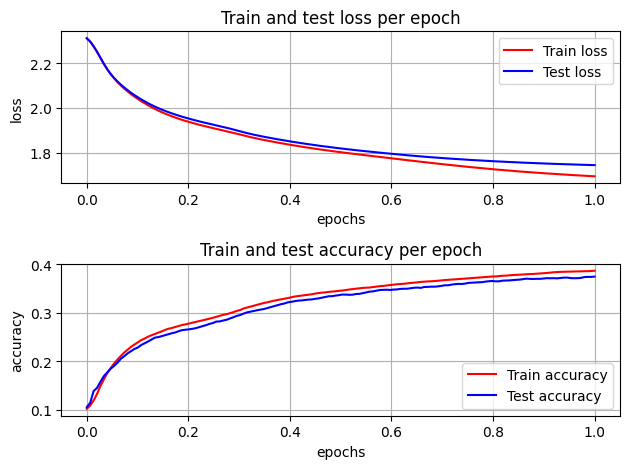

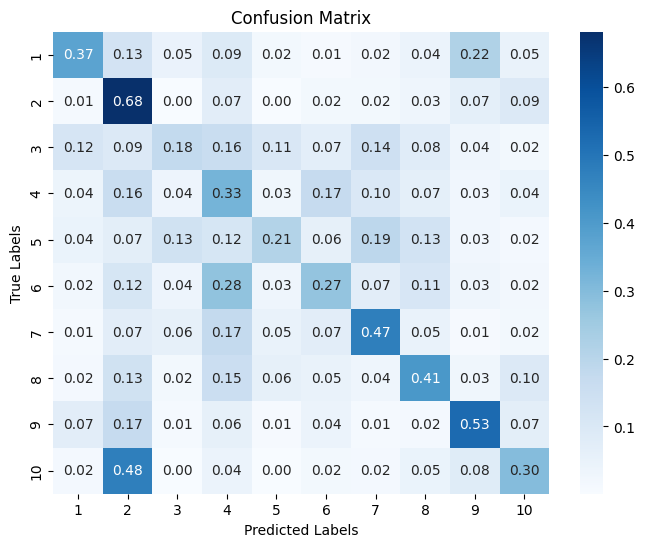

In [7]:
centers = np.array(compute_centroids(train_data.cpu().numpy(),train_labels.cpu().numpy()))
dists = np.linalg.norm(centers[:, np.newaxis] - centers, axis=2)
centers = torch.tensor(centers).to(device)
# Find the maximum distance
max_distance = np.max(dists)
sigma = max_distance/np.sqrt(2*10)

model1 = Model0(gaussian,centers,sigma,10).to(device)
loss_fun = nn.CrossEntropyLoss()
#optim = torch.optim.SGD(params=model1.parameters(),lr = 0.01)
optim = torch.optim.Adam(params=model1.parameters(),lr=0.1)
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model_batch(model1,train_dataloader,test_dataloader,loss_fun,optim,epochs=150)
plot_graphs(train_losses,test_losses,train_accuracies,test_accuracies)
preds = test_step_batch(model1,test_dataloader,loss_fun,return_preds=True)
plot_confusion_matrix(test_labels,preds,class_names)


Η απόδοση είναι περίπου 37%, που δεν είναι καθόλου καλή. Φαίνεται ότι ίσως αλλάζοντας την αρχικοποίηση των κέντρων συγκλίνουμε πιο γρήγορα και έχουμε καλύτερο αποτέλεσμα. Δοκιμάζουμε λοιπόν τη χρήση k-means όπως προτείνει η βιβλιογραφία.

Sigma: 1597.5768909038393
epoch 0 	train loss: 2.02978 	test loss: 1.97818 	train_acc = 24.86	test_acc = 25.98 	lr=0.1
epoch 1 	train loss: 1.95972 	test loss: 1.94508 	train_acc = 27.51	test_acc = 27.49 	lr=0.1
epoch 2 	train loss: 1.93326 	test loss: 1.92313 	train_acc = 28.61	test_acc = 28.56 	lr=0.1
epoch 3 	train loss: 1.91199 	test loss: 1.90280 	train_acc = 29.57	test_acc = 29.67 	lr=0.1
epoch 4 	train loss: 1.89193 	test loss: 1.88380 	train_acc = 30.62	test_acc = 30.54 	lr=0.1
epoch 5 	train loss: 1.87418 	test loss: 1.86802 	train_acc = 31.42	test_acc = 31.58 	lr=0.1
epoch 6 	train loss: 1.85901 	test loss: 1.85517 	train_acc = 32.22	test_acc = 32.42 	lr=0.1
epoch 7 	train loss: 1.84601 	test loss: 1.84428 	train_acc = 32.90	test_acc = 32.85 	lr=0.1
epoch 8 	train loss: 1.83461 	test loss: 1.83449 	train_acc = 33.46	test_acc = 33.32 	lr=0.1
epoch 9 	train loss: 1.82435 	test loss: 1.82549 	train_acc = 33.90	test_acc = 33.66 	lr=0.1
epoch 10 	train loss: 1.81517 	test loss: 1.

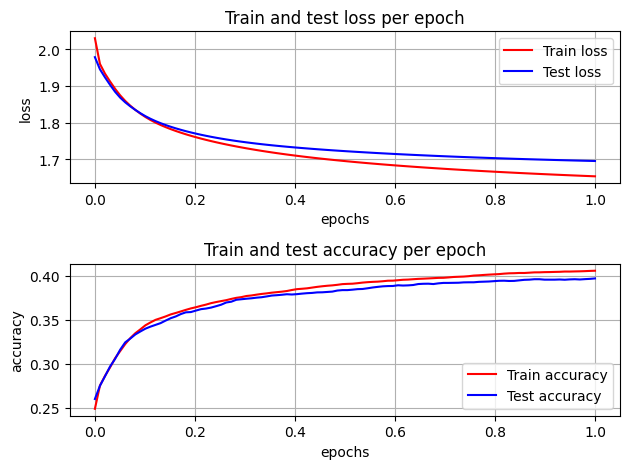

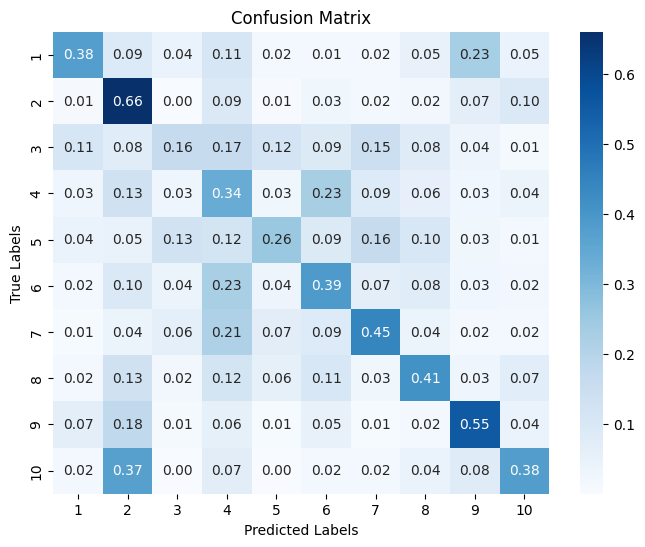

In [8]:
numb_clusters = 10
kmeans = KMeans(n_clusters=numb_clusters, random_state=0).fit(train_data.cpu().numpy())

# Calculate pairwise distances using broadcasting
dists = np.linalg.norm(kmeans.cluster_centers_[:, np.newaxis] - kmeans.cluster_centers_, axis=2)

# Find the maximum distance
max_distance = np.max(dists)
sigma = max_distance/np.sqrt(2*numb_clusters)

print(f"Sigma: {sigma}")

centers = torch.tensor(kmeans.cluster_centers_).to(device)    
model1 = Model0(gaussian,centers,sigma,numb_clusters).to(device)
loss_fun = nn.CrossEntropyLoss()
#optim = torch.optim.SGD(params=model1.parameters(),lr = 0.01)
optim = torch.optim.Adam(params=model1.parameters(),lr=0.1)
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model_batch(model1,train_dataloader,test_dataloader,loss_fun,optim,epochs=100)
plot_graphs(train_losses,test_losses,train_accuracies,test_accuracies)
preds = test_step_batch(model1,test_dataloader,loss_fun,return_preds=True)
plot_confusion_matrix(test_labels,preds,class_names)


Μέσα σε 100 epochs έχουμε καλύτερο αποτέλεσμα σε σχέση με προηγουμένως, όπου τρέξαμε τον κώδικα για 150 epochs. Στην περίπτωση αυτή βρισκόμαστε κοντά στο 40% accuracy. Παρ'όλα αυτά, και πάλι το αποτέλεσμα δεν είναι ικανοποιητικό. Μπορούμε να δοκιμάσουμε να αυξήσουμε τις συναρτήσεις kernel ώστε να γίνουν περισσότερες από 10. 

Θα δοκιμάσουμε 50, και μετά 100 ώστε να δούμε αν η ακρίβειά μας βελτιώνεται.

Sigma: 938.21416015625
epoch 0 	train loss: 2.16697 	test loss: 2.11433 	train_acc = 19.00	test_acc = 21.21 	lr=0.1
epoch 1 	train loss: 2.08044 	test loss: 2.06613 	train_acc = 23.08	test_acc = 23.40 	lr=0.1
epoch 2 	train loss: 2.03596 	test loss: 2.03419 	train_acc = 25.20	test_acc = 24.88 	lr=0.1
epoch 3 	train loss: 2.00232 	test loss: 2.00874 	train_acc = 26.76	test_acc = 25.99 	lr=0.1
epoch 4 	train loss: 1.97399 	test loss: 1.98630 	train_acc = 27.96	test_acc = 26.89 	lr=0.1
epoch 5 	train loss: 1.94873 	test loss: 1.96564 	train_acc = 29.08	test_acc = 28.09 	lr=0.1
epoch 6 	train loss: 1.92581 	test loss: 1.94662 	train_acc = 29.99	test_acc = 29.04 	lr=0.1
epoch 7 	train loss: 1.90495 	test loss: 1.92920 	train_acc = 30.89	test_acc = 29.89 	lr=0.1
epoch 8 	train loss: 1.88583 	test loss: 1.91334 	train_acc = 31.74	test_acc = 30.77 	lr=0.1
epoch 9 	train loss: 1.86814 	test loss: 1.89893 	train_acc = 32.54	test_acc = 31.19 	lr=0.1
epoch 10 	train loss: 1.85170 	test loss: 1.885

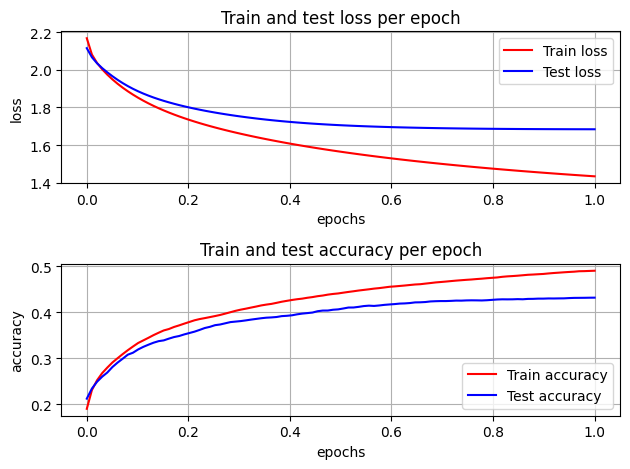

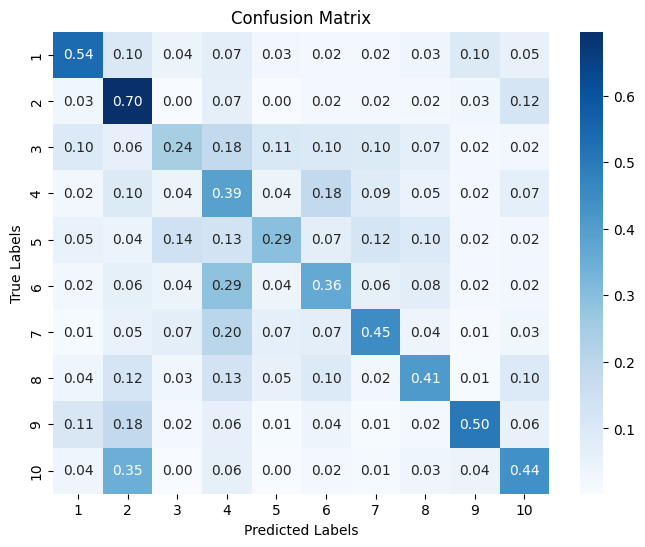

In [9]:
numb_clusters = 50
kmeans = KMeans(n_clusters=numb_clusters, random_state=0).fit(train_data.cpu().numpy())

# Calculate pairwise distances using broadcasting
dists = np.linalg.norm(kmeans.cluster_centers_[:, np.newaxis] - kmeans.cluster_centers_, axis=2)

# Find the maximum distance
max_distance = np.max(dists)
sigma = max_distance/np.sqrt(2*numb_clusters)

print(f"Sigma: {sigma}")

centers = torch.tensor(kmeans.cluster_centers_).to(device)    
model1 = Model0(gaussian,centers,sigma,numb_clusters).to(device)
loss_fun = nn.CrossEntropyLoss()
#optim = torch.optim.SGD(params=model1.parameters(),lr = 0.01)
optim = torch.optim.Adam(params=model1.parameters(),lr=0.1)
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model_batch(model1,train_dataloader,test_dataloader,loss_fun,optim,epochs=100)
plot_graphs(train_losses,test_losses,train_accuracies,test_accuracies)
preds = test_step_batch(model1,test_dataloader,loss_fun,return_preds=True)
plot_confusion_matrix(test_labels,preds,class_names)


Sigma: 705.9204438329552
epoch 0 	train loss: 2.26048 	test loss: 2.23207 	train_acc = 13.32	test_acc = 16.26 	lr=0.1
epoch 1 	train loss: 2.19596 	test loss: 2.18921 	train_acc = 17.02	test_acc = 17.72 	lr=0.1
epoch 2 	train loss: 2.15262 	test loss: 2.15529 	train_acc = 19.49	test_acc = 19.36 	lr=0.1
epoch 3 	train loss: 2.11683 	test loss: 2.12670 	train_acc = 21.14	test_acc = 20.75 	lr=0.1
epoch 4 	train loss: 2.08567 	test loss: 2.10203 	train_acc = 22.60	test_acc = 21.99 	lr=0.1
epoch 5 	train loss: 2.05748 	test loss: 2.08011 	train_acc = 24.01	test_acc = 23.13 	lr=0.1
epoch 6 	train loss: 2.03150 	test loss: 2.06004 	train_acc = 25.25	test_acc = 24.29 	lr=0.1
epoch 7 	train loss: 2.00732 	test loss: 2.04121 	train_acc = 26.37	test_acc = 25.41 	lr=0.1
epoch 8 	train loss: 1.98457 	test loss: 2.02347 	train_acc = 27.45	test_acc = 26.46 	lr=0.1
epoch 9 	train loss: 1.96309 	test loss: 2.00719 	train_acc = 28.43	test_acc = 27.28 	lr=0.1
epoch 10 	train loss: 1.94281 	test loss: 1.9

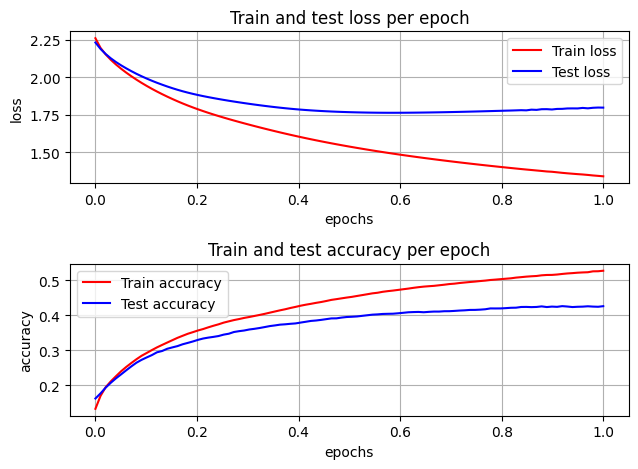

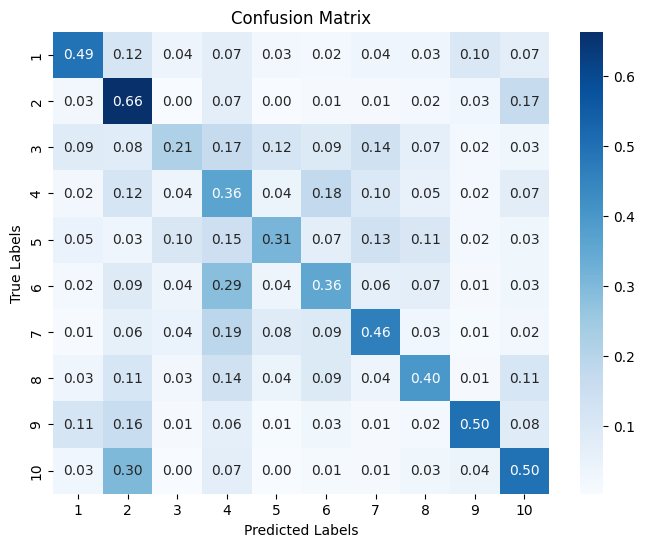

In [10]:
numb_clusters = 100
kmeans = KMeans(n_clusters=numb_clusters, random_state=0).fit(train_data.cpu().numpy())

# Calculate pairwise distances using broadcasting
dists = np.linalg.norm(kmeans.cluster_centers_[:, np.newaxis] - kmeans.cluster_centers_, axis=2)

# Find the maximum distance
max_distance = np.max(dists)
sigma = max_distance/np.sqrt(2*numb_clusters)

print(f"Sigma: {sigma}")

centers = torch.tensor(kmeans.cluster_centers_).to(device)    
model1 = Model0(gaussian,centers,sigma,numb_clusters).to(device)
loss_fun = nn.CrossEntropyLoss()
#optim = torch.optim.SGD(params=model1.parameters(),lr = 0.01)
optim = torch.optim.Adam(params=model1.parameters(),lr=0.1)
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model_batch(model1,train_dataloader,test_dataloader,loss_fun,optim,epochs=100)
plot_graphs(train_losses,test_losses,train_accuracies,test_accuracies)
preds = test_step_batch(model1,test_dataloader,loss_fun,return_preds=True)
plot_confusion_matrix(test_labels,preds,class_names)


Παρατηρούμε ότι με την αύξηση των kernels σε 50, έχουμε μικρή αύξηση του accuracy στο 42%, ενώ με μεγαλύτερη αύξηση των kernels στα 100, το accuracy δεν αλλάζει σχεδόν καθόλου. Ο χρόνος εκτέλεσης του προγράμματος αυξάνεται σημαντικά σε κάθε περίπτωση. Στην πρώτη περίπτωση ήταν περίπου 10λ ενώ στη δεύτερη 17λ. Αρκεί να σημειώσουμε ότι με 10 kernel functions ο κώδικας έτρεχε σε 3λ.

Μπορούμε τώρα να δοκιμάσουμε τη χρήση των δεδομένων μετά από PCA για την κατηγοριοποίηση. Κρατάμε 90% της πληροφορίας και τρέχουμε τον κώδικα με τα δεδομένα μετά απο PCA, με 50 kernel functions. Πιθανών η απόρριψη πληροφορίας μέσω του PCA να μας βοηθήσει στην κατηγοριοποίηση και επίσης θα κάνει τον κώδικά μας να τρέχει πιο γρήγορα. Ας το δούμε στην πράξη.

Sigma: 14.62613525390625
epoch 0 	train loss: 2.30648 	test loss: 2.30028 	train_acc = 10.01	test_acc = 10.08 	lr=0.1
epoch 1 	train loss: 2.30036 	test loss: 2.29563 	train_acc = 10.02	test_acc = 12.81 	lr=0.1
epoch 2 	train loss: 2.29575 	test loss: 2.29195 	train_acc = 12.74	test_acc = 12.96 	lr=0.1
epoch 3 	train loss: 2.29210 	test loss: 2.28733 	train_acc = 13.00	test_acc = 13.29 	lr=0.1
epoch 4 	train loss: 2.28749 	test loss: 2.28148 	train_acc = 13.36	test_acc = 14.33 	lr=0.1
epoch 5 	train loss: 2.28165 	test loss: 2.27546 	train_acc = 14.51	test_acc = 18.12 	lr=0.1
epoch 6 	train loss: 2.27562 	test loss: 2.26992 	train_acc = 18.00	test_acc = 14.38 	lr=0.1
epoch 7 	train loss: 2.27005 	test loss: 2.26460 	train_acc = 14.24	test_acc = 19.06 	lr=0.1
epoch 8 	train loss: 2.26470 	test loss: 2.25886 	train_acc = 18.86	test_acc = 18.85 	lr=0.1
epoch 9 	train loss: 2.25892 	test loss: 2.25249 	train_acc = 18.83	test_acc = 19.89 	lr=0.1
epoch 10 	train loss: 2.25249 	test loss: 2.2

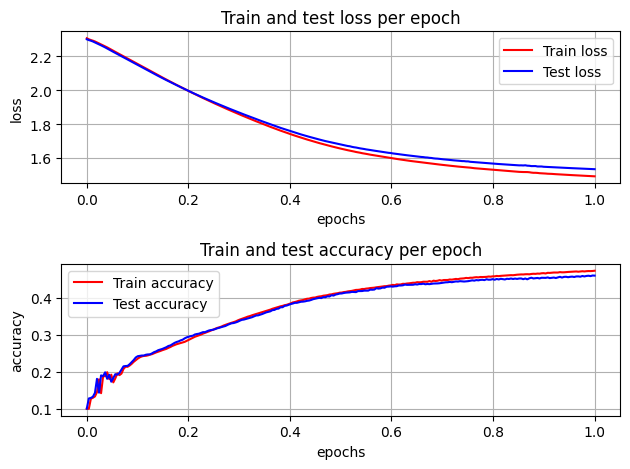

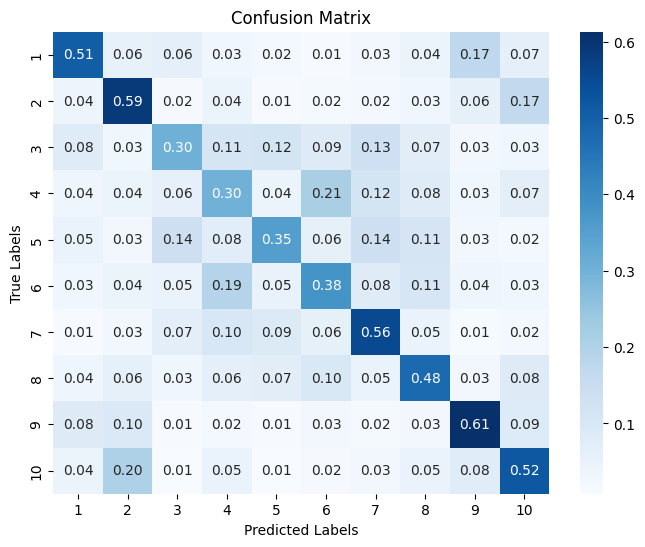

In [11]:
numb_clusters = 50

kmeans = KMeans(n_clusters=numb_clusters, random_state=0).fit(train_data_t.cpu().numpy())

# Calculate pairwise distances using broadcasting
dists = np.linalg.norm(kmeans.cluster_centers_[:, np.newaxis] - kmeans.cluster_centers_, axis=2)

# Find the maximum distance
max_distance = np.max(dists)
sigma = max_distance/np.sqrt(2*numb_clusters)

print(f"Sigma: {sigma}")

centers = torch.tensor(kmeans.cluster_centers_).to(device)    
model1 = Model0(gaussian,centers,sigma,numb_clusters,103).to(device)
loss_fun = nn.CrossEntropyLoss()
#optim = torch.optim.SGD(params=model1.parameters(),lr = 0.01)
optim = torch.optim.Adam(params=model1.parameters(),lr=0.1)
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model(model1,train_data_t,train_labels,test_data_t,test_labels,loss_fun,optim,epochs=250)
# train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model_batch(model1,train_dataloader,test_dataloader,loss_fun,optim,epochs=100)
plot_graphs(train_losses,test_losses,train_accuracies,test_accuracies)
preds = test_step(model1,test_data_t,test_labels,loss_fun,return_preds=True)
plot_confusion_matrix(test_labels,preds,class_names)


Παρατηρούμε οτι το accuracy έγινε περίπου 46% μετά από 250 epochs. Βλέπαμε ότι δεν είχαμε overfitting οπότε τρέξαμε τον αλγόριθμο για όσα epochs χρειαζόταν μέχρι να φτάσουμε στην βέλτιστη λύση. Δεν έχουμε μεγάλες αλλαγές σε σχέση με προηγουμένως χωρίς PCA, όμως η σύγκλισή μας γίνεται πολύ πιο αργά. Ο κώδικάς μας έτρεχε για περίπου 16λ.

Τέλος, μιας και τα hog features δούλεψαν πολύ καλά σε κάθε περίπτωση της cifar-10, θα ελέγξουμε και πάλι αν βοηθήσουν το RBF μας να πετύχει μεγαλύτερα ποσοστά ακρίβειας. Επειδή τα hog features είναι normalized, θα μειώσουμε το learning rate στο 0.01 ειδάλλως δεν θα έχουμε σύγκλιση. 

In [6]:
def extract_hog_features(train_data: np.array, test_data: np.array):
    hog_features = np.zeros((50000,324),np.float32)
    for index1,image in enumerate(train_data):
            hog_features[index1], hog_image = hog(image.transpose(1,2,0),pixels_per_cell=(8, 8),cells_per_block=(2, 2),visualize=True,channel_axis=-1,transform_sqrt=True)
    hog_features_t = np.zeros((10000,324),np.float32)
    for index1,image in enumerate(test_data):
        hog_features_t[index1], hog_image = hog(image.transpose(1,2,0),pixels_per_cell=(8, 8),cells_per_block=(2, 2),visualize=True,channel_axis=-1,transform_sqrt=True)
    return hog_features,hog_features_t

In [13]:
hog_features_train,hog_features_test = extract_hog_features(images_sep,images_sep_t)

In [14]:
#Combination of all the data in vector form for batch training
tr_data = TensorDataset(torch.from_numpy(hog_features_train).type(torch.float32).to(device),train_labels)
te_data = TensorDataset(torch.from_numpy(hog_features_test).type(torch.float32).to(device),test_labels)
train_dataloader_hog= DataLoader(tr_data, batch_size=BATCH_SIZE,shuffle=False)
test_dataloader_hog = DataLoader(te_data,batch_size = BATCH_SIZE, shuffle=False)

Sigma: 0.41376350481023993
epoch 0 	train loss: 2.16446 	test loss: 2.03443 	train_acc = 19.54	test_acc = 27.12 	lr=0.001
epoch 1 	train loss: 1.97578 	test loss: 1.92972 	train_acc = 31.63	test_acc = 32.95 	lr=0.001
epoch 2 	train loss: 1.90739 	test loss: 1.88155 	train_acc = 34.51	test_acc = 34.39 	lr=0.001
epoch 3 	train loss: 1.86765 	test loss: 1.84724 	train_acc = 35.85	test_acc = 35.57 	lr=0.001
epoch 4 	train loss: 1.83709 	test loss: 1.81933 	train_acc = 37.01	test_acc = 36.57 	lr=0.001
epoch 5 	train loss: 1.80787 	test loss: 1.78828 	train_acc = 37.99	test_acc = 37.55 	lr=0.001
epoch 6 	train loss: 1.78045 	test loss: 1.76451 	train_acc = 39.02	test_acc = 38.71 	lr=0.001
epoch 7 	train loss: 1.75822 	test loss: 1.74364 	train_acc = 39.93	test_acc = 39.58 	lr=0.001
epoch 8 	train loss: 1.73835 	test loss: 1.72486 	train_acc = 40.75	test_acc = 40.45 	lr=0.001
epoch 9 	train loss: 1.72036 	test loss: 1.70783 	train_acc = 41.49	test_acc = 40.88 	lr=0.001
epoch 10 	train loss: 1

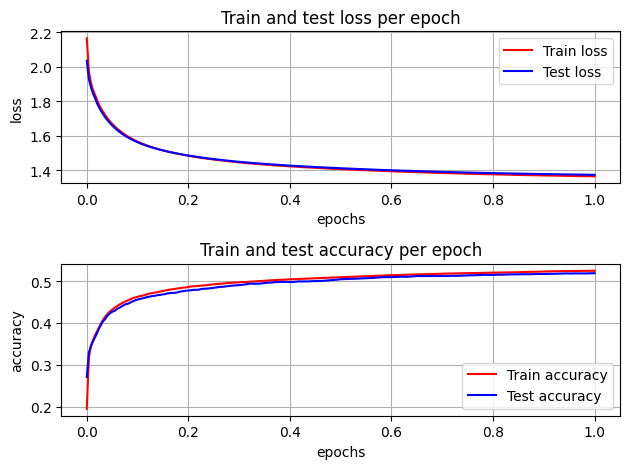

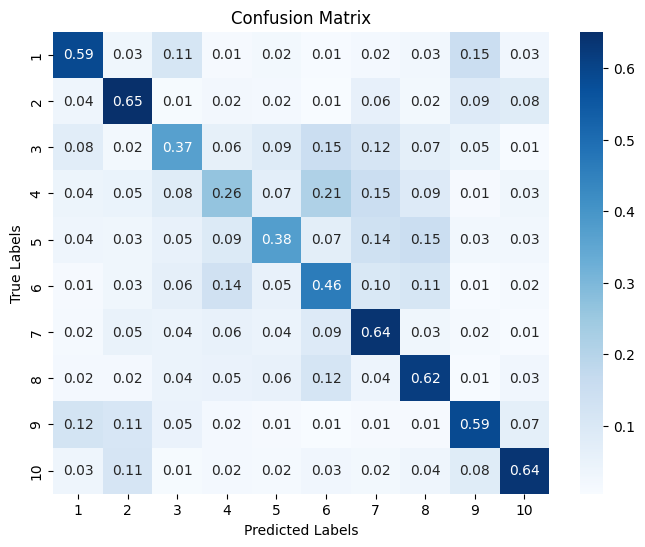

In [16]:
numb_clusters = 10

kmeans = KMeans(n_clusters=numb_clusters, random_state=0).fit(hog_features_train)

# Calculate pairwise distances using broadcasting
dists = np.linalg.norm(kmeans.cluster_centers_[:, np.newaxis] - kmeans.cluster_centers_, axis=2)

# Find the maximum distance
max_distance = np.max(dists)
sigma = max_distance/np.sqrt(2*numb_clusters)

print(f"Sigma: {sigma}")

centers = torch.tensor(kmeans.cluster_centers_).to(device)    
model1 = Model0(gaussian,centers,sigma,numb_clusters,324).to(device)
loss_fun = nn.CrossEntropyLoss()
# Reduce the learning rate
optim = torch.optim.Adam(params=model1.parameters(),lr=0.001)
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model_batch(model1,train_dataloader_hog,test_dataloader_hog,loss_fun,optim,epochs=250)
# train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model_batch(model1,train_dataloader,test_dataloader,loss_fun,optim,epochs=100)
plot_graphs(train_losses,test_losses,train_accuracies,test_accuracies)
preds = test_step_batch(model1,test_dataloader_hog,loss_fun,return_preds=True)
plot_confusion_matrix(test_labels,preds,class_names)


Παρατηρούμε ότι με προεργασία των δεδομένων εξάγοντας τα HOG features, το accuracy του RBF μας μπορεί να φτάσει πάνω απο 50% και η σύγκλισή του είναι σχετικά γρήγορη (στην περίπτωσή μας 4λ).

## Συμπέρασμα

Παρατηρούμε ότι τα αποτελέσματα του RBF μας δεν είναι ικανοποιητικά, με το μεγαλύτερο ποσοστό επιτυχίας να είναι το 42% χωρίς προεπεξεργασία, και το 52% με προεπεξεργασία εξάγοντας τα HOG features. Με τη χρήση 1-NN στην ενδιάμεση εργασία είχαμε ποσοστό επιτυχίας 35%, με 3-ΝΝ 33% και με Nearest Centroid είχαμε 27%. Φαίνεται ότι η χρήση RBF είναι καλύτερη απ'ότι η χρήση των αλγορίθμων αυτών για τη cifar-10. Όσων αφορά τα αποτελέσματα με τη χρήση hog features, με τους προαναφερόμενους αλγορίθμους πετυχαίναμε ποσοστά περίπου στο 49% ενώ το RBF μας έδωσε 52% επιτυχία. Συνεπώς, μπορούμε να πούμε ότι η χρήση του RBF είναι πιο αποδοτική.

Και πάλι όμως, η απόδοση του RBF NN μας δεν μπορεί να θεωρηθεί ικανοποιητική. Μερικούς από τους λόγους που το RBF μας δίνει τόσο φτωχά αποτελέσματα, είναι επειδή το cifar-10 είναι ενα dataset με υψηλό αριθμό διαστάσεων, συγκεκριμένα 3072. Τα RBFs γενικά δουλεύουν καλύτερα σε προβλήματα μικρών διαστάσεων. Επίσης, το RBF εξαρτάται από τη γεωμετρία του dataset στο feature space. Επειδή το cifar-10 είναι dataset με εικόνες, είναι γνωστό ότι λύσεις που ασχολούνται με τη γεωμετρία του προβλήματος στον τομέα της αναγνώρισης εικόνων δεν δίνουν υψηλά αποτελέσματα. 